In [27]:
# Celda de configuración
# Elegir qué métodos ejecutar
CORRER_ECUACIONES_NORMALES = True
CORRER_SVD = True
CORRER_QR = True

ALEATORIZAR_MUESTRAS = True   # mezclar antes de recortar columnas

# Semilla para reproducibilidad en el recorte
# Sirve para que, si ALEATORIZAR_MUESTRAS=True, la selección aleatoria de columnas sea siempre la misma (resultados reproducibles).
SEMILLA_REDUCCION = 287238


# TP2 - Benchmark de algoritmos

Este notebook:
- Carga los embeddings de `cats_and_dogs` y sus etiquetas (train/val)
- Entrena un clasificador lineal `W` con dos métodos:
  - Ecuaciones Normales (factorización de Cholesky)
  - Pseudo-inversa vía SVD
- Compara tiempos de entrenamiento y accuracy en validación



In [28]:
from pathlib import Path
import time
import numpy as np
import alc
import matplotlib.pyplot as plt

# Directorio del dataset (relativo al repo)
RUTA_DATASET = Path('template-alumnos/dataset/cats_and_dogs')
assert RUTA_DATASET.exists(), f'No se encontró el dataset en {RUTA_DATASET.resolve()}'


In [29]:
# Recarga de módulos de la librería de la cátedra
import importlib


# Luego recargar el paquete para refrescar los símbolos
moduloALC = importlib.reload(alc)

# Reasignar alias usado en el notebook
alc = moduloALC


In [30]:

# Carga de datos usando cargarDataset del main (con posible reducción)
X_train, Y_train, X_val, Y_val = alc.cargarDataset(str(RUTA_DATASET))

def reducir_tamanio(X_a_reducir, Y_a_reducir, max_columnas_train, semilla_reducir=SEMILLA_REDUCCION):
    if X_a_reducir.shape[1] >= max_columnas_train:
        indices = np.arange(X_a_reducir.shape[1])
        if ALEATORIZAR_MUESTRAS:
            rng = np.random.default_rng(semilla_reducir)
            rng.shuffle(indices)
        indices = indices[:max_columnas_train]
        X_train_reducido = X_train[:, indices]
        Y_train_reducido = Y_train[:, indices]
        return X_train_reducido, Y_train_reducido
    
    return X_a_reducir, Y_a_reducir


In [31]:
def exactitud_desde_puntajes(W: np.ndarray, X: np.ndarray, Y_verdadera: np.ndarray) -> float:
    puntajes = alc.productoMatricial(W, X)
    y_pred = np.argmax(puntajes, axis=0)
    y_true = np.argmax(Y_verdadera, axis=0)
    return float(np.mean(y_pred == y_true))


def obtener_resultados(X_reducido, Y_reducido):
    resultados = {}

    # Ecuaciones Normales (Cholesky)
    if CORRER_ECUACIONES_NORMALES:
        inicio = time.perf_counter()
        W_normal = alc.pinvEcuacionesNormales(X_reducido, None, Y_reducido)
        Tiempo_entrenamiento_normal = time.perf_counter() - inicio

        acc_train_normal = exactitud_desde_puntajes(W_normal, X_reducido, Y_reducido)
        acc_val_normal = exactitud_desde_puntajes(W_normal, X_val, Y_val)

        resultados['ecuaciones_normales'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_normal,
            'exactitud_train': acc_train_normal,
            'exactitud_val': acc_val_normal,
        }

    # SVD
    if CORRER_SVD:
        inicio = time.perf_counter()
        U, S, V = alc.svd_reducida(X_reducido)
        W_svd = alc.pinvSVD(U, S, V, Y_reducido)
        Tiempo_entrenamiento_svd = time.perf_counter() - inicio

        acc_train_svd = exactitud_desde_puntajes(W_svd, X_reducido, Y_reducido)
        acc_val_svd = exactitud_desde_puntajes(W_svd, X_val, Y_val)

        resultados['SVD'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_svd,
            'exactitud_train': acc_train_svd,
            'exactitud_val': acc_val_svd,
        }

    # QR
    if CORRER_QR:
        # Gram-Schmidt
        Q_gs, R_gs = alc.QR_con_GS_MatRectangular(alc.traspuesta(X_reducido))
        inicio = time.perf_counter()
        W_qr_gs = alc.pinvGramSchmidt(Q_gs, R_gs, Y_reducido)
        Tiempo_entrenamiento_qr_gs = time.perf_counter() - inicio
        acc_train_qr_gs = exactitud_desde_puntajes(W_qr_gs, X_reducido, Y_reducido)
        acc_val_qr_gs = exactitud_desde_puntajes(W_qr_gs, X_val, Y_val)
        resultados['QR_GS'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_qr_gs,
            'exactitud_train': acc_train_qr_gs,
            'exactitud_val': acc_val_qr_gs,
        }

        # Householder
        Q_hh, R_hh = alc.QR_con_HH(alc.traspuesta(X_reducido))
        inicio = time.perf_counter()
        W_qr_hh = alc.pinvHouseHolder(Q_hh, R_hh, Y_reducido)
        Tiempo_entrenamiento_qr_hh = time.perf_counter() - inicio
        acc_train_qr_hh = exactitud_desde_puntajes(W_qr_hh, X_reducido, Y_reducido)
        acc_val_qr_hh = exactitud_desde_puntajes(W_qr_hh, X_val, Y_val)
        resultados['QR_HH'] = {
            'tiempo_entrenamiento_s': Tiempo_entrenamiento_qr_hh,
            'exactitud_train': acc_train_qr_hh,
            'exactitud_val': acc_val_qr_hh,
        }

    return resultados


In [ ]:
# Mostrar resultados y gráficos de comparación
def mostrar_resultados(resultados):
    print('Resultados:')
    for metodo, valores in resultados.items():
        print(f"\nMétodo: {metodo}")
        print(f"  tiempo entrenamiento (s): {valores['tiempo_entrenamiento_s']:.4f}")
        print(f"  exactitud train: {valores['exactitud_train']:.4f}")
        print(f"  exactitud val  : {valores['exactitud_val']:.4f}")

    metodos = list(resultados.keys())
    tiempos = [resultados[m]['tiempo_entrenamiento_s'] for m in metodos]
    exactitudes_train = [resultados[m]['exactitud_train'] for m in metodos]
    exactitudes = [resultados[m]['exactitud_val'] for m in metodos]

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(metodos, tiempos, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#937860', '#DA8BC3', '#7C4D7D', '#C496B5', '#A4A4A4', '#B56576'])
    plt.title('Tiempo de entrenamiento (s)')
    plt.ylabel('segundos')

    plt.subplot(1,2,2)
    plt.bar(metodos, exactitudes, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#937860', '#DA8BC3', '#7C4D7D', '#C496B5', '#A4A4A4', '#B56576'])
    plt.title('Exactitud en validación')
    plt.ylim(0, 1)

    plt.subplot(1,2,2)
    plt.bar(metodos, exactitudes_train, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#937860', '#DA8BC3', '#7C4D7D', '#C496B5', '#A4A4A4', '#B56576'])
    plt.title('Exactitud en entrenamiento')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()
    
    
X_50, Y_50 = reducir_tamanio(X_train, Y_train, 50, 32432)
X_100, Y_100 = reducir_tamanio(X_train, Y_train, 100, 231232)
X_250, Y_250 = reducir_tamanio(X_train, Y_train, 250, 12353)
X_500, Y_500 = reducir_tamanio(X_train, Y_train, 500, 2321124)
X_2000, Y_2000 = reducir_tamanio(X_train, Y_train, 2000, 21323)

CORRER_QR = False # necesita n < p

print("Resultados para matriz reducida a 50 columnas:")
mostrar_resultados(obtener_resultados(X_50, Y_50))

print("Resultados para matriz reducida a 100 columnas:")
mostrar_resultados(obtener_resultados(X_100, Y_100))

print("Resultados para matriz reducida a 250 columnas:")
mostrar_resultados(obtener_resultados(X_250, Y_250))

print("Resultados para matriz reducida a 500 columnas:")
mostrar_resultados(obtener_resultados(X_500, Y_500))

CORRER_QR = True

print("Resultados para matriz reducida a 2000 columnas:")
mostrar_resultados(obtener_resultados(X_2000, Y_2000))


Resultados para matriz reducida a 50 columnas:


KeyboardInterrupt: 

In [43]:
def comparar_numero_condicion(M1: np.ndarray,
                               M2: np.ndarray,
                               p=2,
                               nombres=("M1", "M2"),
                               usar_gram_si_no_cuadrada: bool = True):
    """
    Imprime el número de condición (según p) de dos matrices y su diferencia.
    Usa alc.condExacto (p en {1, 'inf'}). Si una matriz no es cuadrada y
    usar_gram_si_no_cuadrada=True, usa una matriz de Gram adecuada:
      - X.T @ X si n >= p
      - X @ X.T si n < p
    """
    def _prepara_matriz(M: np.ndarray):
        if M.shape[0] == M.shape[1] or not usar_gram_si_no_cuadrada:
            return M
        # Elegimos Gram que quede del tamaño más chico (mejor chance de rango completo)
        if M.shape[0] >= M.shape[1]:
            # n >= p → usar X.T @ X (p x p)
            return alc.productoMatricial(alc.traspuesta(M), M)
        else:
            # n < p → usar X @ X.T (n x n)
            return alc.productoMatricial(M, alc.traspuesta(M))

    def _cond(M: np.ndarray):
        A = _prepara_matriz(M)
        try:
            return alc.condExacto(A, p)
        except Exception:
            # Respaldo: cálculo Monte Carlo cuando condExacto no aplica
            return alc.condMC(A, p)

    k1 = _cond(M1)
    k2 = _cond(M2)
    diff = k2 - k1

    print(f"Número de condición (p={p}) {nombres[0]}: {k1:.6g}")
    print(f"Número de condición (p={p}) {nombres[1]}: {k2:.6g}")
    print(f"Diferencia ({nombres[1]} - {nombres[0]}): {diff:.6g}")

Número de condición (p=2) M1: 22.7596
Número de condición (p=2) M2: 193621
Diferencia (M2 - M1): 193598
Número de condición (p=2) M1: 22.1189
Número de condición (p=2) M2: 22.7754
Diferencia (M2 - M1): 0.656525
Resultados para matriz reducida a 50 columnas con duplicados:
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 2.2373
  exactitud train: 0.7200
  exactitud val  : 0.4970

Método: SVD
  tiempo entrenamiento (s): 6.5031
  exactitud train: 1.0000
  exactitud val  : 0.5000


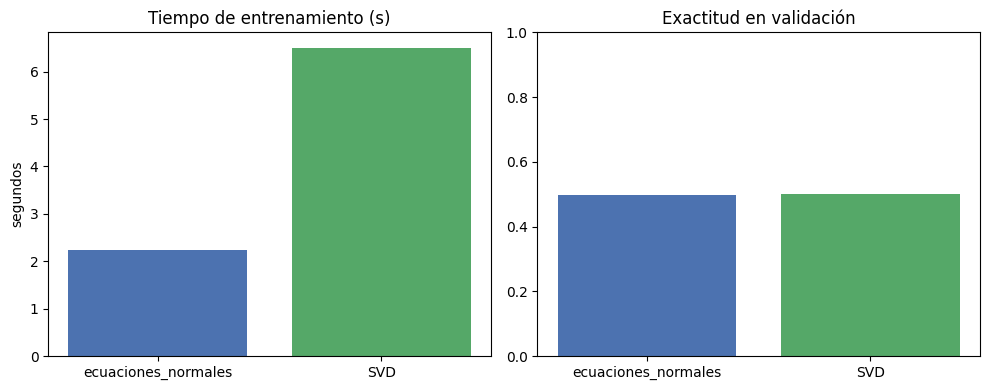

Resultados para matriz reducida a 50 columnas con dependientes:
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 2.3555
  exactitud train: 1.0000
  exactitud val  : 0.5320

Método: SVD
  tiempo entrenamiento (s): 7.1155
  exactitud train: 1.0000
  exactitud val  : 0.5430


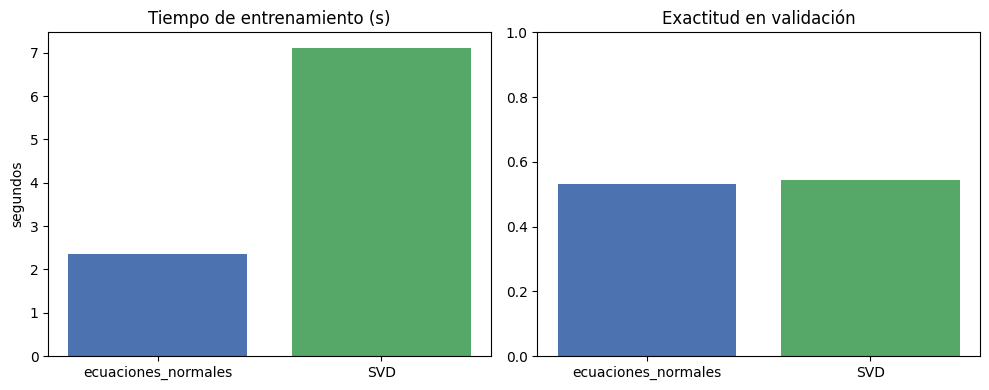

Número de condición (p=2) M1: 45.2912
Número de condición (p=2) M2: 328342
Diferencia (M2 - M1): 328297
Número de condición (p=2) M1: 43.6883
Número de condición (p=2) M2: 43.3899
Diferencia (M2 - M1): -0.298448
Resultados para matriz reducida a 100 columnas con duplicados:
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 9.6389
  exactitud train: 0.6800
  exactitud val  : 0.5080

Método: SVD
  tiempo entrenamiento (s): 53.1425
  exactitud train: 1.0000
  exactitud val  : 0.4990


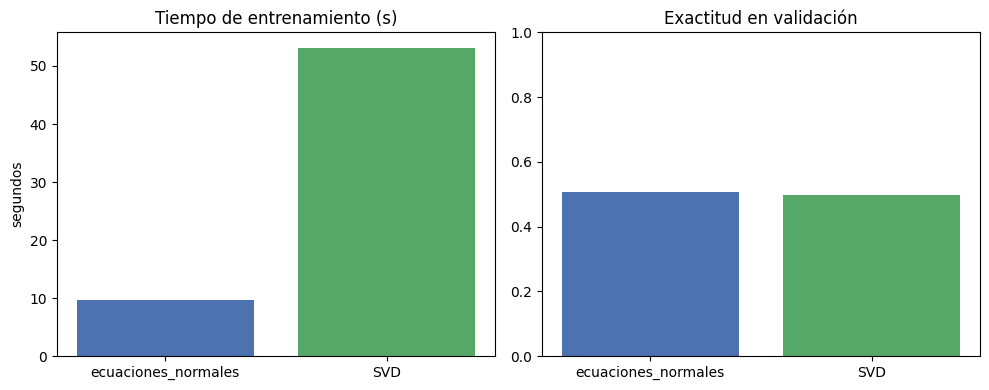

Resultados para matriz reducida a 100 columnas con dependientes:
Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 9.2530
  exactitud train: 0.8800
  exactitud val  : 0.5320

Método: SVD
  tiempo entrenamiento (s): 56.3144
  exactitud train: 1.0000
  exactitud val  : 0.5640


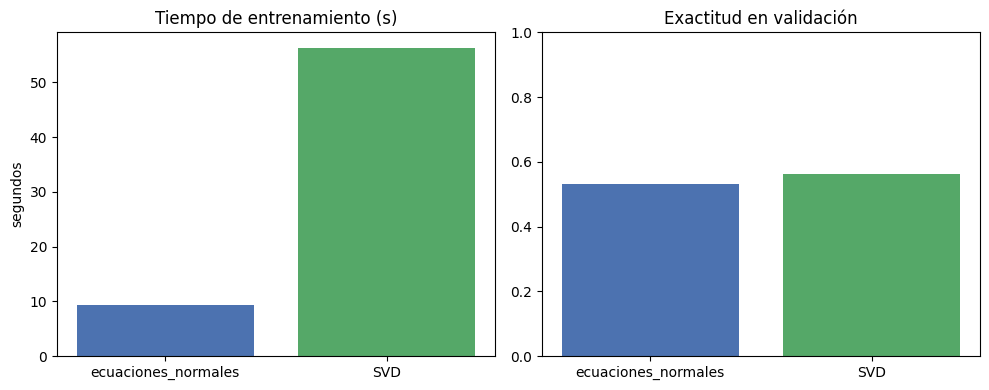

In [44]:
CORRER_QR = False # necesita n < p

# Opción 1: columnas casi duplicadas, SIN agregar columnas
X_50_cond_aumentado_duplicado, Y_50_cond_aumentado_duplicado = alc.aumentar_numero_condicion(
    X_50, Y_50,
    metodo='duplicar_columnas',
    n_duplicados=40,        # ~15% de p
    ruido_rel=1e-2,        # empieza en 1e-2; si es muy chico, puede gatillar pivote ≈ 0
    semilla=42,
    modo='reemplazar'      # clave: no extiende p
)

comparar_numero_condicion(X_50, X_50_cond_aumentado_duplicado)

# Opción 2: filas casi dependientes
X_50_cond_aumentado_dependiente, Y_50_cond_aumentado_dependiente = alc.aumentar_numero_condicion(
    X_50, Y_50,
    metodo='dependencia_filas',
    pares_dependencias=10,
    ruido_rel=1e-3,
    semilla=42
)

comparar_numero_condicion(X_50, X_50_cond_aumentado_dependiente)


print("Resultados para matriz reducida a 50 columnas con duplicados:")
mostrar_resultados(obtener_resultados(X_50_cond_aumentado_duplicado, Y_50_cond_aumentado_duplicado))

print("Resultados para matriz reducida a 50 columnas con dependientes:")
mostrar_resultados(obtener_resultados(X_50_cond_aumentado_dependiente, Y_50_cond_aumentado_dependiente))

# Opción 1: columnas casi duplicadas, SIN agregar columnas
X_100_cond_aumentado_duplicado, Y_100_cond_aumentado_duplicado = alc.aumentar_numero_condicion(
    X_100, Y_100,
    metodo='duplicar_columnas',
    n_duplicados=40,        # ~15% de p
    ruido_rel=1e-2,        # empieza en 1e-2; si es muy chico, puede gatillar pivote ≈ 0
    semilla=42,
    modo='reemplazar'      # clave: no extiende p
)

comparar_numero_condicion(X_100, X_100_cond_aumentado_duplicado)

# Opción 2: filas casi dependientes
X_100_cond_aumentado_dependiente, Y_100_cond_aumentado_dependiente = alc.aumentar_numero_condicion(
    X_100, Y_100,
    metodo='dependencia_filas',
    pares_dependencias=8,
    ruido_rel=1e-3,
    semilla=42
)

comparar_numero_condicion(X_100, X_100_cond_aumentado_dependiente)

print("Resultados para matriz reducida a 100 columnas con duplicados:")
mostrar_resultados(obtener_resultados(X_100_cond_aumentado_duplicado, Y_100_cond_aumentado_duplicado))

print("Resultados para matriz reducida a 100 columnas con dependientes:")
mostrar_resultados(obtener_resultados(X_100_cond_aumentado_dependiente, Y_100_cond_aumentado_dependiente))

